# pyUCell - some important parameters

This document describes some important parameters of the pyUCell algorithm, and how they can be adapted depending on your dataset.

For a simple pyUCell tutorial refer to: [pyUCell basics](https://pyucell.readthedocs.io/en/latest/notebooks/basic.html#)

## Load example dataset

In [1]:
import scanpy as sc
import pyucell as uc

In [2]:
adata = sc.datasets.pbmc3k()

**Note:** becase UCell scores are based on relative gene ranks, it can be applied both on raw counts or normalized data. As long as the normalization preserves the relative ranks between genes, the results will be equivalent.

## 1. Positive and negative gene sets in signatures

pyUCell supports **positive and negative gene sets** within a signature. Simply append + or - signs to the genes to include them in positive and negative sets, respectively. For example:

In [3]:
signatures = {"CD8T": ["CD8A+", "CD8B+", "CD4-"], "CD4T": ["CD4+", "CD40LG+", "CD8A-", "CD8B-"]}

pyUCell evaluates the positive and negative gene sets separately, then subtracts the scores. The parameter `w_neg` controls the relative weight of the negative gene set compared to the positive set (`w_neg=1.0` means equal weight). Note that the combined score is clipped to zero, to preserve UCell scores in the [0, 1] range.

In [4]:
uc.compute_ucell_scores(adata, signatures=signatures, w_neg=1)

In [5]:
adata.obs

,CD8T_UCell,CD4T_UCell
index,,
AAACATACAACCAC-1,0.770771,0.000000
AAACATTGAGCTAC-1,0.000000,0.000000
AAACATTGATCAGC-1,0.000000,0.252586
AAACCGTGCTTCCG-1,0.000000,0.000000
AAACCGTGTATGCG-1,0.000000,0.000000
...,...,...
TTTCGAACTCTCAT-1,0.000000,0.000000
TTTCTACTGAGGCA-1,0.000000,0.000000
TTTCTACTTCCTCG-1,0.000000,0.000000


## 2. The `max_rank` parameter

Single-cell data are sparse. In other words, for any given cell only a few hundred/a few thousand genes (out of tens of thousands) are detected with at least one UMI count. Because UCell scores are based on ranking genes by their expression values, it is essential to account for data sparsity when calculating ranks. This is implemented by capping ranks to a `max_rank` parameter, in other words only the top `max_rank` genes are ranked, and the rest are assumed equivalent at the lowest ranking value.

It is often useful to adjust the `max_rank` depending on the sparsity of your dataset. A good rule of thumb is to examine the median number of expressed genes per cell, and set `max_rank` in that order of magnitude. For example, for the test dataset:

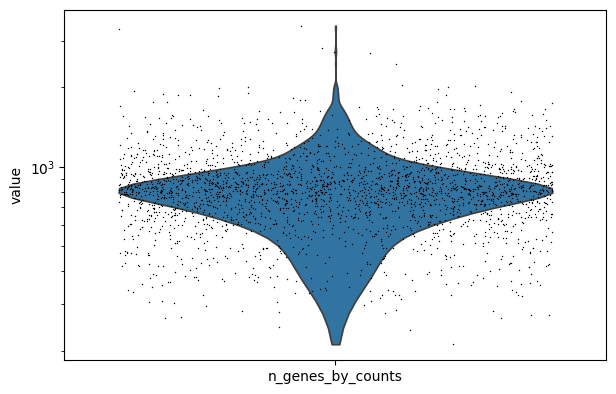

In [7]:
aa = adata.copy()
sc.pp.calculate_qc_metrics(aa, inplace=True)

sc.pl.violin(aa, "n_genes_by_counts", jitter=0.4, size=1, log=True, groupby=None)

This dataset has relatively low depth, so it is advisable to choose a `max_rank` around `800-1000` (from the default `1500`)

In [8]:
uc.compute_ucell_scores(adata, signatures=signatures, max_rank=800)

This is even more important when applying pyUCell to technologies/modalities of much lower dimensionality, for example probe-based spatial transcriptomics data (e.g. Xenium, CosMx), or antibody tags (ADT) in CITE-seq experiments. Xenium panels contain a few hundred/a few thousand genes; CITE-seq can detect a few hundred proteins, as opposed to thousands of genes in scRNA-seq. The `max_rank` parameter should then also be adjusted to reflect the new dimensionality and set to no more than the number of probes in the panel.

## 3. Handling missing genes

If a subset of the genes in your signature are absent from the count matrix, how should they be handled?

pyUCell offers two alternative ways of handling missing genes:
- `missing_genes="impute"` (default): it assumes that absence from the count matrix means zero expression. All values for this gene are imputed to zero.
-  `missing_genes="skip"`: simply exclude all missing genes from the signatures; they won't contribute to the scores.

In [9]:
signatures = {"CD8T": ["CD8A+", "CD8B+", "CD4-", "notagene"]}
uc.compute_ucell_scores(adata, signatures=signatures, missing_genes="impute")
adata.obs

,CD8T_UCell,CD4T_UCell
index,,
AAACATACAACCAC-1,0.514019,0.000000
AAACATTGAGCTAC-1,0.000000,0.000000
AAACATTGATCAGC-1,0.000000,0.035692
AAACCGTGCTTCCG-1,0.000000,0.000000
AAACCGTGTATGCG-1,0.000000,0.000000
...,...,...
TTTCGAACTCTCAT-1,0.000000,0.000000
TTTCTACTGAGGCA-1,0.000000,0.000000
TTTCTACTTCCTCG-1,0.000000,0.000000


In [10]:
uc.compute_ucell_scores(adata, signatures=signatures, missing_genes="skip")
adata.obs

,CD8T_UCell,CD4T_UCell
index,,
AAACATACAACCAC-1,0.770771,0.000000
AAACATTGAGCTAC-1,0.000000,0.000000
AAACATTGATCAGC-1,0.000000,0.035692
AAACCGTGCTTCCG-1,0.000000,0.000000
AAACCGTGTATGCG-1,0.000000,0.000000
...,...,...
TTTCGAACTCTCAT-1,0.000000,0.000000
TTTCTACTGAGGCA-1,0.000000,0.000000
TTTCTACTTCCTCG-1,0.000000,0.000000


## 4. Chunk size

UCell scores are calculated individually for each cell (though they may be later [smoothed](https://pyucell.readthedocs.io/en/latest/notebooks/knn.html) by nearest-neighbor similarity). This means that computation can be easily split into batches, reducing the computational footprint of gene ranking and enabling parallel processing (see below). The size of the batches is controlled by the `chunk_size` parameter. Large chunks take up more RAM, while small chunk sizes have large overhead from dataset splitting and merging. A sweet spot for `chunk_size` is usually in the order of 100-1000 cells per batch.

In [11]:
uc.compute_ucell_scores(adata, signatures=signatures, chunk_size=100)

## 5. Parallelization

Parallelization is handled internally by `joblib` and the `Parallel` module. You may control the number of jobs with the `n_jobs` parameter. By default all available cores are used (`n_jobs=-1`).

In [14]:
%time uc.compute_ucell_scores(adata, signatures=signatures, n_jobs=1)

CPU times: user 774 ms, sys: 18.8 ms, total: 793 ms
Wall time: 789 ms


In [15]:
%time uc.compute_ucell_scores(adata, signatures=signatures, n_jobs=4)

CPU times: user 46.3 ms, sys: 17.2 ms, total: 63.5 ms
Wall time: 474 ms


## References

If you used UCell in your research, please cite:

**UCell: robust and scalable single-cell gene signature scoring.** Massimo Andreatta & Santiago J Carmona (2021) 
CSBJ - [doi.org/10.1016/j.csbj.2021.06.043](https://doi.org/10.1016/j.csbj.2021.06.043)